<a href="https://colab.research.google.com/github/yohai/eyes/blob/main/eyes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import plotly
# from google.colab import files
from stl import mesh as stl_mesh
from sklearn.decomposition import PCA
import numpy as np
import plotly.graph_objects as go
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xarray as xr
from scipy.ndimage import minimum_filter
import matplotlib as mpl

def read_mesh(filepath, transform=False):
    """stl_mesh is read by nympy-stl from a stl file. it is an array of
    faces/triangles (i.e. three 3d points) this function extracts the unique
    vertices and the lists I, J, K to define a Plotly mesh3d """
    m = stl_mesh.Mesh.from_file(filepath)
    p, q, r = m.vectors.shape #(p, 3, 3)
    # the array stl_mesh.vectors.reshape(p*q, r) can contain multiple copies of
    # the same vertex; extract unique vertices from all mesh triangles
    vertices, ixr = np.unique(m.vectors.reshape(p*q, r), return_inverse=True, axis=0)
    x, y, z = vertices.T
    i = np.take(ixr, [3*k for k in range(p)])
    j = np.take(ixr, [3*k+1 for k in range(p)])
    k = np.take(ixr, [3*k+2 for k in range(p)])
    return x, y, z, i, j, k

def find_local_minima(matrix):
  min_filter = minimum_filter(matrix, size=3)
  local_minima = (matrix == min_filter)

  #remove border minima
  local_minima[:, 0] = local_minima[:, -1] = False
  local_minima[0, :] = local_minima[-1, :] = False

  coordinates = np.column_stack(np.where(local_minima))
  return coordinates

In [2]:
def reflect_points(points, theta, c):
  """reflects point in 3d around a z-parallel plane defined by
            cos(theta) x + sin(theta) y = c
  """
  a, b = np.cos(theta), np.sin(theta)
  n = np.array([a, b, 0])[:, np.newaxis]
  n_norm_sq = np.sum(n ** 2)

  # Calculate the reflected points
  dot_product = np.sum(points * n, axis=0) - c
  reflected_points = points - 2 * (dot_product / n_norm_sq) * n

  return reflected_points


def reflection_axis(theta, offset, scale=1):
  """returns the line (mpl artist) of the reflection axis for visualization"""
  n = np.array([np.cos(theta), np.sin(theta)])
  v = np.array([-np.sin(theta), np.cos(theta)])
  p1 = n * offset + v * scale
  p2 = n * offset - v * scale
  ps = np.array([p1, p2])
  return mpl.lines.Line2D(*ps.T, linestyle='--', color='k')

def add_axs_to_fig(fig, cs):
    # Line part of the arrow
    for c, color in zip(cs, ['red', 'green', 'blue']):
      x, y, z = c
      line = go.Scatter3d(x=[0, x], y=[0, y], z=[0, z], mode='lines',
                          line=dict(width=5, color=color))
      cone = go.Cone(x=[x], y=[y], z=[z], u=[x], v=[y], w=[z],
                     sizemode='scaled', sizeref=0.1)
      fig.add_trace(line)
      fig.add_trace(cone)
class Face():
  def __init__(self, x, y, z, i, j, k):
    self.x = x
    self.y = y
    self.z = z
    self.i = i
    self.j = j
    self.k = k

  def center(self):
    self.x -= self.x.mean()
    self.y -= self.y.mean()
    self.z -= self.z.mean()
    return self

  def copy(self):
    return Face(x=self.x, y=self.y, z=self.z, i=self.i, j=self.j, k=self.k)

  @classmethod
  def from_file(cls, filepath):
    return Face(*read_mesh(filepath))

  def mesh(self, **kwargs):
    return go.Mesh3d(x=self.x, y=self.y, z=self.z, i=self.i, j=self.j, k=self.k,
                     **kwargs)

  def vertices(self):
    """Returns an array of shape (3, n_points)"""
    return np.array([self.x, self.y, self.z])

  def plane(self):
    L = (self.z.max() - self.z.min())
    plane_range = np.linspace(-L, L, 3)
    px, py = np.meshgrid(plane_range, plane_range)

    # YZ plane at x=0
    yz_plane = go.Surface(x=px*0, y=py, z=px, opacity=0.5)
    return yz_plane

  def to_heightmap(self, xi, yi):
    """xi, yi are the gridded coordinates"""
    x, y, z = self.vertices()
    # Interpolate z values on the 2D meshgrid
    zi = griddata((x, y), z, (xi, yi), method='cubic')
    return zi

  def pca_rotate(self):
    vs = self.vertices()
    pca = PCA(n_components=3).fit(vs.T)
    cs = pca.components_
    self.x, self.y, self.z = cs @ vs
    return self

  def reflect(self, theta, offset):
    self.x, self.y, self.z = reflect_points(self.vertices(), theta, offset)
    return self

  def xy_grid(self, npoints=400):
    x, y, z = self.vertices()
    Lx = (max(x) - min(x)) / 2
    Ly = (max(y) - min(y)) / 2
    L = max(Lx, Ly) * 1.5
    xi, yi = np.meshgrid(
        np.linspace(-L, L, npoints),
        np.linspace(-L, L, npoints)
        )
    return xi, yi

  def reflection_distance(self, theta, offset, npoints=400):
    x, y = self.xy_grid(npoints=npoints)
    face2 = self.copy()
    face2.reflect(theta, offset)

    z1 = self.to_heightmap(x, y)
    z2 = face2.to_heightmap(x, y)

    return np.nanmean(np.abs(z1-z2))

In [3]:
face = Face.from_file('scans/example2.stl').center()
face.pca_rotate()
face2 = face.copy()
face2.reflect(60*np.pi/180, 0)
fig = go.Figure(data=[
    face.mesh(color='cyan', lighting={
        'diffuse':.9,
        'fresnel': .4,
        'ambient': 0.6,
        'specular': 0.4
        }),
    face2.mesh(color='green', lighting={
        'diffuse':.9,
        'fresnel': .4,
        'ambient': 0.6,
        'specular': 0.4
        }),
])

fig.show()

In [4]:
face1 = Face.from_file('scans/example2.stl').center()
face1.pca_rotate()
face1.center()


theta = np.linspace(0,np.pi)
d = np.array([reflection_distance(face1, t, 0, 200) for t in tqdm(theta)])

  0%|          | 0/50 [00:00<?, ?it/s]

NameError: name 'reflection_distance' is not defined

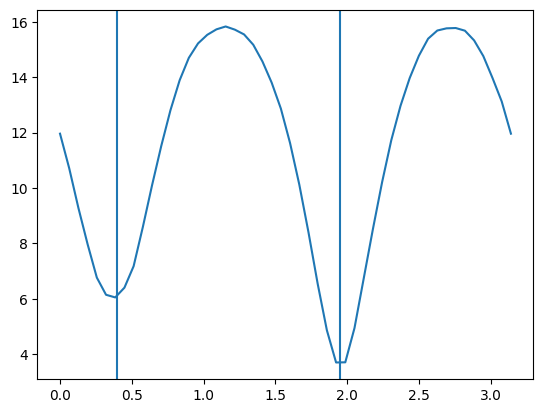

In [8]:
plt.plot(theta, d)
good_theta = np.array([0.4, 1.95])
[plt.axvline(v) for v in good_theta]

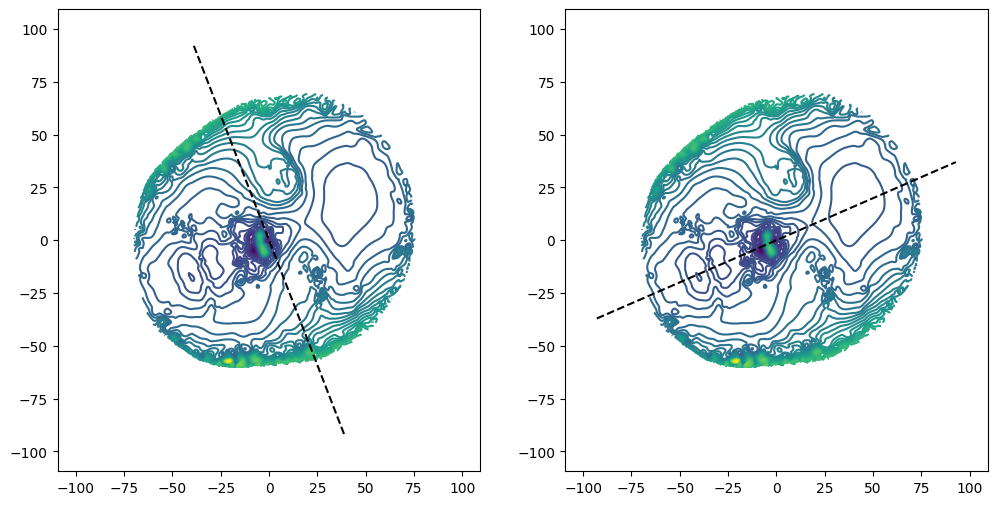

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

x, y = face1.xy_grid()
z1 = face1.to_heightmap(x, y)
axs[0].contour(x,y,z1, levels=50)
axs[1].contour(x,y,z1, levels=50)

for i in [0, 1]:
  axs[i].add_artist(reflection_axis(good_theta[i], 0, scale=100))

In [36]:
from scipy.optimize import minimize

def create_func(face, npoints):
  def objective_func(params):
      theta, offset = params
      # Your function here, for example:
      return face.reflection_distance(theta=theta, offset=offset, npoints=npoints)
  return objective_func

# Bound constraints
theta_bounds = (0, np.pi)
offset_bounds = (-10, 10)  # Replace 10 with your specific L value
bounds = [theta_bounds, offset_bounds]

# Initial guess
initial_guess = [1.9, 0]

face1 = Face.from_file('example2.stl').center()
face1.pca_rotate()
face1.center()
face1.x += 18

f = create_func(face1, 50)
result = minimize(f, initial_guess, bounds=bounds, method='Nelder-Mead')

# Extract results
if result.success:
    optimized_theta, optimized_offset = result.x
    print(f"Optimal point: theta = {optimized_theta}, offset = {optimized_offset}")
else:
    print("Optimization failed:", result.message)


Optimal point: theta = 1.8412750604005461, offset = -0.5499182548953421


In [31]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3.558982220063281
             x: [ 1.950e+00  2.030e-03]
           nit: 34
          nfev: 69
 final_simplex: (array([[ 1.950e+00,  2.030e-03],
                       [ 1.950e+00,  2.011e-03],
                       [ 1.950e+00,  1.957e-03]]), array([ 3.559e+00,  3.559e+00,  3.559e+00]))

In [26]:
f([1.9, 2])

3.9524434886584046

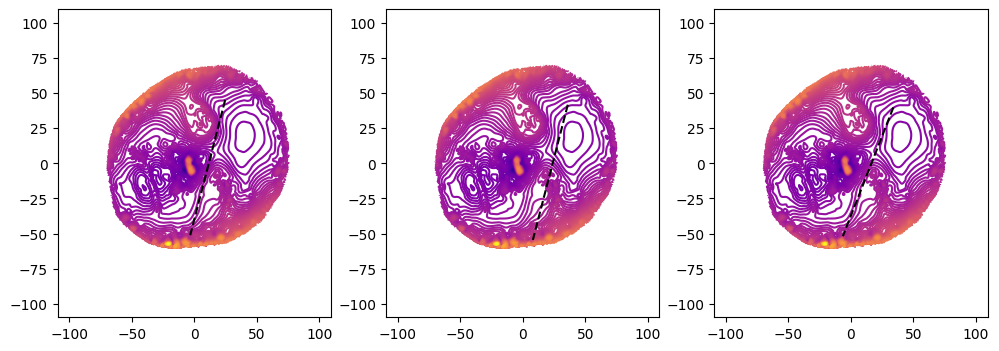

In [98]:
face = Face.from_file('example2.stl').center()
face.pca_rotate()

theta = np.linspace(0, np.pi, 50)
offset = np.linspace(-20, 20, 30)
dist = np.zeros([len(theta), len(offset)])
for i, t in enumerate(tqdm(theta)):
  for j, o in enumerate(tqdm(offset, leave=False)):
    dist[i, j] = reflection_distance(face, t, o)
d = xr.DataArray(dist, dims=['theta', 'offset'], coords={'theta': theta, 'offset': offset}, name='distance')